In [4]:
from numpy import zeros, resize, sqrt, histogram, hstack, vstack, savetxt, zeros_like
import scipy.cluster.vq as vq
import libsvm
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.cluster.vq import whiten
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

In [2]:
# clips_feature_train = np.load('./resnet-18-kinetics_avgpool_train.npy')
# clips_feature_val = np.load('./resnet-18-kinetics_avgpool_val.npy')
# clips_feature_train = np.load('./resnet-18-kinetics_layer4_train.npy')
# clips_feature_val = np.load('./resnet-18-kinetics_layer4_val.npy')
# clips_feature_train = whiten(np.load('./resnet-18-kinetics_hmdb_layer4_train.npy'))
# clips_feature_val = whiten(np.load('./resnet-18-kinetics_hmdb_layer4_val.npy'))
clips_feature_train = np.load('./resnext-101-kinetics_avgpool_train.npy')
clips_feature_val = np.load('./resnext-101-kinetics_avgpool_val.npy')
# clips_feature_train = np.load('./resnext-101-kinetics_layer4_train.npy')
# clips_feature_val = np.load('./resnext-101-kinetics_layer4_val.npy')
# clips_feature_train = np.load('./I3D_features_train.npy')
# clips_feature_val = np.load('./I3D_features_val.npy')
# clips_feature_train = np.load('./c3d_fc6_train.npy')
# clips_feature_val = np.load('./c3d_fc6_val.npy')
# idx_train = np.load('./idx_hmdb.npy')
# idx_val = np.load('./idx_hmdb_val.npy')
idx_train = np.load('./idx.npy')
idx_val = np.load('./idx_val.npy')

## solve the different dimension problem, caused by batch, the last batch is ignored
# num_train = min(clips_feature_train.shape[0], idx_train.shape[0])
# num_val = min(clips_feature_val.shape[0], idx_val.shape[0])
# clips_feature_train = clips_feature_train[0:num_train]
# clips_feature_val = clips_feature_val[0:num_val]
# idx_train = idx_train[0:num_train]
# idx_val = idx_val[0:num_val]

In [3]:
def computeHistograms(codebook, descriptors):
    code, dist = vq.vq(descriptors, codebook)
    histogram_of_words, bin_edges = histogram(code,
                                              bins=range(codebook.shape[0] + 1),
                                              normed=True)
    return histogram_of_words

In [5]:
print(clips_feature_train.shape)
print(idx_train.shape)

(115550, 8192)
(115550,)


In [7]:
clips_feature_train = clips_feature_train.reshape(-1, 16)
clips_feature_val = clips_feature_val.reshape(-1, 16)

In [8]:
kmeans = MiniBatchKMeans(n_clusters=300,
                         random_state=0,
                         batch_size=100000,
                         max_iter=20).fit(clips_feature_train)

In [9]:
codebook = kmeans.cluster_centers_
print(codebook)

[[0.33763853 0.35466692 0.36060908 ... 0.68867755 0.7988128  0.7030736 ]
 [1.4993744  1.8619276  1.7433856  ... 2.401876   2.247363   1.5897803 ]
 [0.02511404 0.01550299 0.05588298 ... 0.00534458 0.0060493  0.02213607]
 ...
 [2.1093268  2.6861446  2.4446168  ... 3.182396   2.8890123  1.9054327 ]
 [1.9239924  2.6453862  2.6855187  ... 3.7562525  3.8117375  2.7377074 ]
 [2.454914   3.6013665  3.8075604  ... 2.137364   2.2956166  1.8086958 ]]


In [6]:
codebook = kmeans.cluster_centers_
print(codebook)

[[0.03863481 0.02101904 0.02128839 ... 0.02421943 0.02219688 0.0431468 ]
 [0.09493156 0.0483611  0.05496676 ... 0.02416526 0.02321071 0.03744178]
 [0.08516553 0.03417907 0.02378263 ... 0.02324733 0.02311163 0.04564283]
 ...
 [0.22170204 0.1734366  0.18738589 ... 0.01798192 0.01965259 0.0361514 ]
 [0.04068788 0.02397627 0.02697668 ... 0.02847276 0.02857929 0.04912072]
 [0.03932214 0.02090194 0.02137628 ... 0.01935699 0.0139389  0.0216152 ]]


In [ ]:
nfeatures = clips_feature_train.shape[0]
print(nfeatures)
nclusters = int(sqrt(nfeatures))
#nclusters = 500
codebook, distortion = vq.kmeans(clips_feature_train,
                                         nclusters)

115520


In [12]:
print(nclusters)

339


In [13]:
print(clips_feature_train.shape)

(115550, 8192)


In [3]:
# clips_classname_train = np.load('./class_names_hmdb_train.npy')
# clips_classname_val = np.load('./class_names_hmdb_val.npy')
clips_classname_train = np.load('./class_names_train.npy')
clips_classname_val = np.load('./class_names_val.npy')
segments = []
video_label = []
previous_name = clips_classname_train[0]
#tmp_clips_feature_train = clips_feature_train.reshape(-1, 256, 98)
i = 0
for name, label in zip(clips_classname_train, idx_train):
    if name != previous_name:
        segments.append(i)
        video_label.append(idx_train[i-1])
    previous_name = name
    i += 1
segments.append(i)
video_label.append(idx_train[i-1])
print(video_label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [7]:
### choose one sample for each class
clips_feature_train = clips_feature_train.reshape(-1, 512, 16)

In [4]:
print(clips_feature_train.shape)

(115550, 2048)


In [5]:
video_features = np.split(clips_feature_train, segments)[:-1]
#video_features = [feature.reshape(-1, 16) for feature in video_features]
#video_features = [np.sum(feature, axis=0) for feature in video_features]

In [6]:
print(video_features[-1].shape)

(13, 2048)


In [36]:
from feature_aggregation import Vlad
vlad = Vlad(101)
vlad.fit(video_features)

Vlad(dimension_ordering='tf', inner_batch=128, n_codewords=101, normalization=3)

In [44]:
from feature_aggregation import FisherVectors
fv = FisherVectors(51)
fv.fit(video_features)

/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


FisherVectors(dimension_ordering='tf', inner_batch=64, max_iter=100,
              n_gaussians=51, n_jobs=-1, n_pca_components=0.8, normalization=3,
              verbose=0)

In [7]:
from feature_aggregation import BagOfWords
bow = BagOfWords(400)
bow.fit(video_features)

/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


BagOfWords(dimension_ordering='tf', l1_norm=True, n_codewords=400)

In [8]:
#new_feature = vlad.transform(video_features)
#new_feature = fv.transform(video_features)
new_feature = bow.transform(video_features)

In [9]:
print(new_feature.shape)

(9537, 400)


In [17]:
video_histogram = []
for video_feature in video_features:
    #video_feature = video_feature.reshape(-1, 16) ## channel as feature extractor
    video_histogram.append(computeHistograms(codebook, video_feature))

/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


In [18]:
print(video_histogram[-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [10]:
#X = preprocessing.normalize(np.array(video_histogram[0:-1]))
X = preprocessing.normalize(new_feature)
y = np.array(video_label)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [11]:
segments_val = []
video_label_val = []
previous_name = clips_classname_val[0]
i = 0
for name,label in zip(clips_classname_val, idx_val):
    if name != previous_name:
        segments_val.append(i)
        video_label_val.append(idx_val[i-1])
    previous_name = name
    i += 1
segments_val.append(i)
video_label_val.append(idx_val[i-1])
#print(video_label_val)

In [15]:
clips_feature_val = clips_feature_val.reshape(-1, 512, 16)

In [12]:
video_features_val = np.split(clips_feature_val, segments_val)[:-1]
#video_features_val = [feature.reshape(-1, 16) for feature in video_features_val]
#video_features_val = [np.sum(feature, axis=0) for feature in video_features_val]

In [13]:
print(video_features_val[0].shape)

(11, 2048)


In [14]:
#new_feature_val = vlad.transform(video_features_val)
#new_feature_val = fv.transform(video_features_val)
new_feature_val = bow.transform(video_features_val)

In [23]:
video_histogram_val = []
for video_feature in video_features_val:
    #video_feature = video_feature.reshape(-1, 16)
    video_histogram_val.append(computeHistograms(codebook, video_feature))

/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


In [15]:
#X_val = preprocessing.normalize(np.array(video_histogram_val))
X_val = preprocessing.normalize(new_feature_val)
y_val = video_label_val
predict = clf.predict(X_val)
accuracy_score(y_val, predict)

0.8355802273328047

In [22]:
print(video_features.shape)

AttributeError: 'list' object has no attribute 'shape'

In [25]:
### for bovw model, the second strategy is to aggregate clip features to video feature first and then kmeans
avg_video_features = np.array([np.average(feature, axis=0) for feature in video_features])
avg_video_features_val = np.array([np.average(feature, axis=0) for feature in video_features_val])

In [26]:
nclusters = int(sqrt(avg_video_features.shape[0]))
print(nclusters)
codebook, distortion = vq.kmeans(avg_video_features,
                                         nclusters)

97


In [27]:
print(avg_video_features.shape)

(9535, 4096)


In [28]:
def getVideoHistogram(codebook, video_features):
    video_histogram = []
    for video_feature in video_features:
        #print(codebook.shape, video_feature.shape)
        video_histogram.append(computeHistograms(codebook, video_feature.reshape(1, -1)))
    return video_histogram

In [29]:
video_histogram = getVideoHistogram(codebook, avg_video_features)
video_histogram_val = getVideoHistogram(codebook, avg_video_features_val)

/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


In [30]:
#X = preprocessing.normalize(np.array(avg_video_features[0:-1])) # svm without bovw
X = preprocessing.normalize(np.array(video_histogram[0:-1])) # svm with bovw
y = np.array(video_label)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [31]:
#X_val = preprocessing.normalize(np.array(avg_video_features_val))
X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = video_label_val
predict = clf.predict(X_val)
accuracy_score(y_val, predict[:-1])

0.39010843692144936

In [32]:
print(video_histogram_val[0].shape)

(97,)


In [7]:
### start feature fusion
def getVideoFeature(clips_feature, segments):
    video_features = np.split(clips_feature, segments)[:-1]
    avg_video_features = np.array([np.average(feature, axis=0) for feature in video_features])
    return preprocessing.normalize(avg_video_features)
    #return avg_video_features

In [11]:
# i3d_clips_feature_train = np.load('./I3D_features_train.npy') ## avg_pool
# i3d_clips_feature_val = np.load('./I3D_features_val.npy')
# c3d_clips_feature_train = np.load('./c3d_fc6_train.npy')
# c3d_clips_feature_val = np.load('./c3d_fc6_val.npy')
i3d_clips_feature_train = np.load('./I3D_features_train.npy') ## avg_pool
i3d_clips_feature_val = np.load('./I3D_features_val.npy')
c3d_clips_feature_train = np.load('./resnext-101-kinetics_avgpool_train.npy')
c3d_clips_feature_val = np.load('./resnext-101-kinetics_avgpool_val.npy')

In [12]:
print(c3d_clips_feature_val.shape)
print(i3d_clips_feature_val.shape)

(45056, 2048)
(45088, 4096)


In [13]:
i3d_video_feature_train = getVideoFeature(i3d_clips_feature_train, segments)
i3d_video_feature_val = getVideoFeature(i3d_clips_feature_val, segments_val)
c3d_video_feature_train = getVideoFeature(c3d_clips_feature_train, segments)
c3d_video_feature_val = getVideoFeature(c3d_clips_feature_val, segments_val)

In [14]:
print(c3d_video_feature_train.shape)
print(len(video_label))

(9535, 2048)
9534


In [6]:
def fuseVideoFeature(video_feature_1, video_feature_2):
    #return np.concatenate((video_feature_1, video_feature_2), axis = 1)
    return np.add(video_feature_1, video_feature_2)

In [26]:
nsample_train = min(i3d_video_feature_train.shape[0], len(video_label))
nsample_val = min(i3d_video_feature_val.shape[0], len(video_label_val))
fuse_video_feature_train = fuseVideoFeature(i3d_video_feature_train, c3d_video_feature_train)[0:nsample_train]
fuse_video_feature_val = fuseVideoFeature(i3d_video_feature_val, c3d_video_feature_val)[0:nsample_val]
label_train = video_label[0:nsample_train]
label_val = video_label_val[0:nsample_val]

ValueError: operands could not be broadcast together with shapes (9535,4096) (9535,2048) 

In [24]:
## video feature fusion followed by svm
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(fuse_video_feature_train, label_train)

predict = clf.predict(fuse_video_feature_val)
accuracy_score(label_val, predict)

0.9057702488088936

In [20]:
## video feature svm without feature fusion
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(c3d_video_feature_train[0:-1], video_label)

predict = clf.predict(c3d_video_feature_val)
accuracy_score(video_label_val, predict[0:-1])

0.8816834303864478

In [28]:
## clip feature svm
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(c3d_clips_feature_train), idx_train)

predict = clf.predict(preprocessing.normalize(c3d_clips_feature_val))
accuracy_score(idx_val, predict)

0.8434392755681818

In [29]:
print(predict.shape)

(45056,)


In [49]:
def clipVoteForVideo(predict, segments_val):
    pred_aggregate = np.split(predict, segments_val)[0:-1]
    pred_vote = [np.argmax(np.bincount(i)) for i in pred_aggregate]
    return pred_vote

In [40]:
accuracy_score(video_label_val, pred_vote[0:-1])

0.8883006881948121

In [51]:
## clip feature fusion followed by svm, svm train using clip, val using clip vote: 4%+ vs clip no vote, 0.1%+ vs video svm
nsample_train = min(i3d_clips_feature_train.shape[0], c3d_clips_feature_train.shape[0])
nsample_val = min(i3d_clips_feature_val.shape[0], c3d_clips_feature_val.shape[0])
fused_clips_feature_train = np.concatenate((i3d_clips_feature_train[0:nsample_train], c3d_clips_feature_train[0:nsample_train]), axis = 1)
fused_clips_feature_val = np.concatenate((i3d_clips_feature_val[0:nsample_val], c3d_clips_feature_val[0:nsample_val]), axis = 1)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(fused_clips_feature_train), idx_train[0:nsample_train])

predict = clf.predict(preprocessing.normalize(fused_clips_feature_val))
accuracy_score(idx_val[0:nsample_val], predict)
#0.8656
pred_video = clipVoteForVideo(predict, segments_val)
accuracy_score(video_label_val, pred_video[0:-1])
#0.9063

0.9062996294335627

In [41]:
## t-sne
video_features = getVideoFeature(clips_feature_train, segments)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(video_features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9530 samples in 0.466s...
[t-SNE] Computed neighbors for 9530 samples in 68.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9530
[t-SNE] Computed conditional probabilities for sample 2000 / 9530
[t-SNE] Computed conditional probabilities for sample 3000 / 9530
[t-SNE] Computed conditional probabilities for sample 4000 / 9530
[t-SNE] Computed conditional probabilities for sample 5000 / 9530
[t-SNE] Computed conditional probabilities for sample 6000 / 9530
[t-SNE] Computed conditional probabilities for sample 7000 / 9530
[t-SNE] Computed conditional probabilities for sample 8000 / 9530
[t-SNE] Computed conditional probabilities for sample 9000 / 9530
[t-SNE] Computed conditional probabilities for sample 9530 / 9530
[t-SNE] Mean sigma: 0.257923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.790237
[t-SNE] KL divergence after 3000 iterations: 0.660263
t-SNE done! Time elapsed: 133.005417

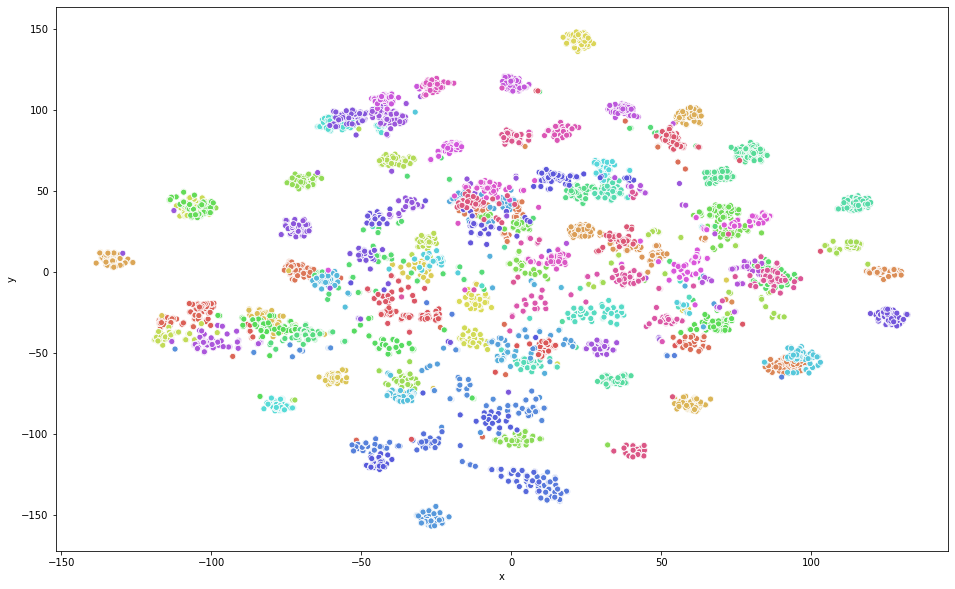

In [43]:
pd_tsne = pd.DataFrame(tsne_results, columns=["x", "y"])
pd_tsne['label'] = video_label

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 101),
    data=pd_tsne,
    legend=False,
    alpha=1
)

In [6]:
def getSegmentsAndVideoLabel(clips_classname, idx):
    segments = []
    video_label = []
    previous_name = clips_classname[0]
    i = 0
    for name, label in zip(clips_classname, idx):
        if name != previous_name:
            segments.append(i)
            video_label.append(idx[i-1])
        previous_name = name
        i += 1
    segments.append(i)
    video_label.append(idx[i-1])
    
    return segments, video_label
    
def getTSNEData(npy_name):
    clips_feature_train = np.load(npy_name + '_train.npy')
    clips_feature_val = np.load(npy_name + '_val.npy')

    idx_train = np.load('./idx.npy')
    idx_val = np.load('./idx_val.npy')
    
    clips_classname_train = np.load('./class_names_train.npy')
    clips_classname_val = np.load('./class_names_val.npy')

    ## solve the different dimension problem, caused by batch, the last batch is ignored
    num_train = min(clips_feature_train.shape[0], idx_train.shape[0], clips_classname_train.shape[0])
    num_val = min(clips_feature_val.shape[0], idx_val.shape[0], clips_classname_val.shape[0])
    clips_feature_train = clips_feature_train[0:num_train]
    clips_feature_val = clips_feature_val[0:num_val]
    idx_train = idx_train[0:num_train]
    idx_val = idx_val[0:num_val]
    clips_classname_train = clips_classname_train[0:num_train]
    clips_classname_val = clips_classname_val[0:num_val]
    
    segments_train, video_label_train = getSegmentsAndVideoLabel(clips_classname_train, idx_train)
    segments_val, video_label_val = getSegmentsAndVideoLabel(clips_classname_val, idx_val)
    
    video_features_train = getVideoFeature(clips_feature_train, segments_train)
    video_features_val = getVideoFeature(clips_feature_val, segments_val) ##avg clip feature to video feature
    
    return video_features_train, video_label_train, video_features_val, video_label_val
    
    
    

In [48]:
c3d_video_features_train, c3d_video_label_train, c3d_video_features_val, c3d_video_label_val = getTSNEData('./resnext-101-kinetics_avgpool')

FileNotFoundError: [Errno 2] No such file or directory: './clip_names_train.npy'

In [55]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(c3d_video_features_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9535 samples in 8.777s...
[t-SNE] Computed neighbors for 9535 samples in 745.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9535
[t-SNE] Computed conditional probabilities for sample 2000 / 9535
[t-SNE] Computed conditional probabilities for sample 3000 / 9535
[t-SNE] Computed conditional probabilities for sample 4000 / 9535
[t-SNE] Computed conditional probabilities for sample 5000 / 9535
[t-SNE] Computed conditional probabilities for sample 6000 / 9535
[t-SNE] Computed conditional probabilities for sample 7000 / 9535
[t-SNE] Computed conditional probabilities for sample 8000 / 9535
[t-SNE] Computed conditional probabilities for sample 9000 / 9535
[t-SNE] Computed conditional probabilities for sample 9535 / 9535
[t-SNE] Mean sigma: 0.309715
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.019753
[t-SNE] KL divergence after 3000 iterations: 1.034370
t-SNE done! Time elapsed: 916.62610

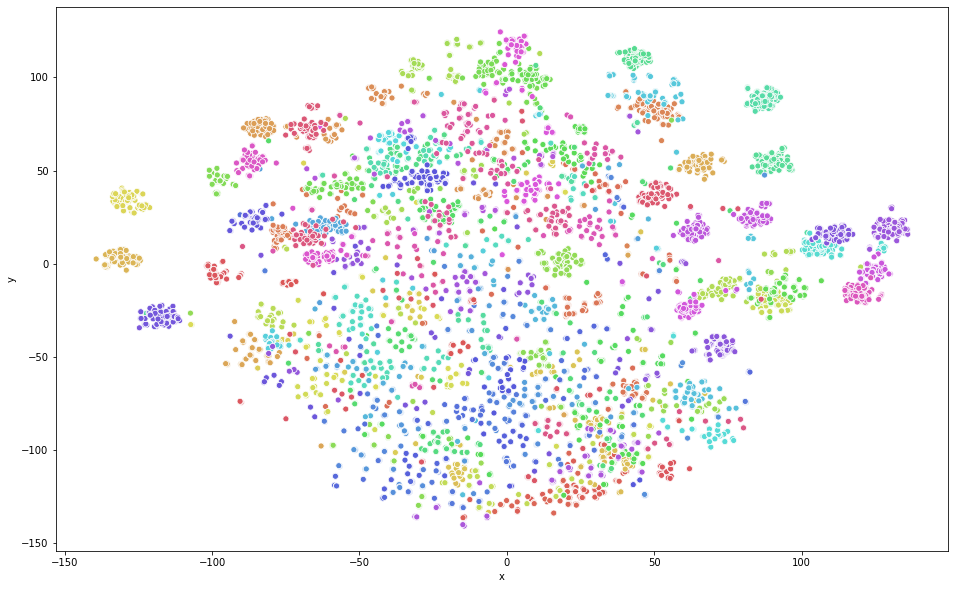

In [56]:
pd_tsne = pd.DataFrame(tsne_results, columns=["x", "y"])
pd_tsne['label'] = c3d_video_label_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 101),
    data=pd_tsne,
    legend=False,
    alpha=1
)

In [57]:
i3d_video_features_train, i3d_video_label_train, i3d_video_features_val, i3d_video_label_val = getTSNEData('./I3D_avg_pool_4096')
print(i3d_video_features_train.shape)

(45056, 4096) 3779
(9535, 4096)


In [80]:
fuse_video_features_train = preprocessing.normalize(np.add(i3d_video_features_train, c3d_video_features_train))


In [81]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(fuse_video_features_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9535 samples in 10.710s...
[t-SNE] Computed neighbors for 9535 samples in 824.763s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9535
[t-SNE] Computed conditional probabilities for sample 2000 / 9535
[t-SNE] Computed conditional probabilities for sample 3000 / 9535
[t-SNE] Computed conditional probabilities for sample 4000 / 9535
[t-SNE] Computed conditional probabilities for sample 5000 / 9535
[t-SNE] Computed conditional probabilities for sample 6000 / 9535
[t-SNE] Computed conditional probabilities for sample 7000 / 9535
[t-SNE] Computed conditional probabilities for sample 8000 / 9535
[t-SNE] Computed conditional probabilities for sample 9000 / 9535
[t-SNE] Computed conditional probabilities for sample 9535 / 9535
[t-SNE] Mean sigma: 0.362296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.493088
[t-SNE] KL divergence after 3000 iterations: 0.979683
t-SNE done! Time elapsed: 1018.669

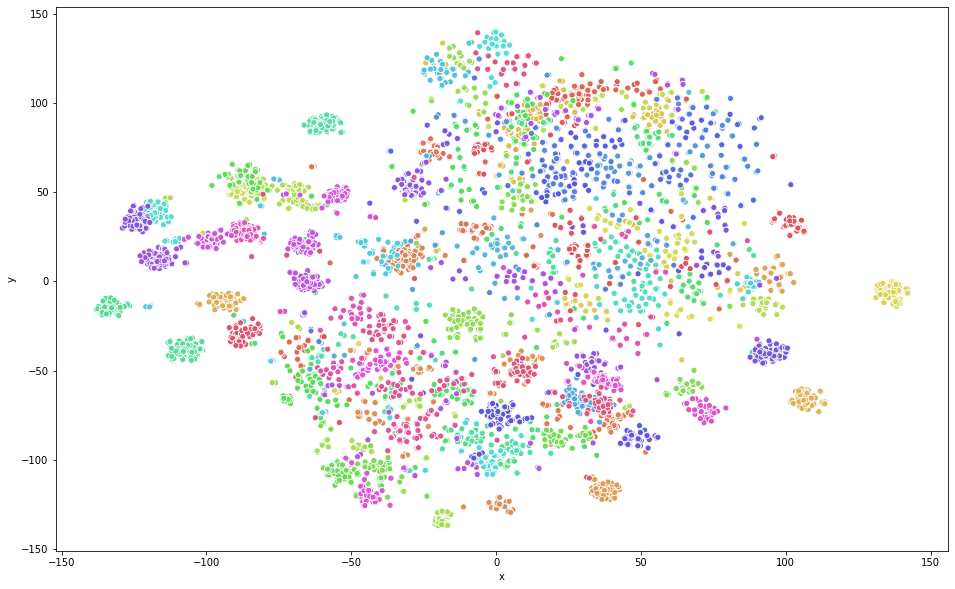

In [82]:
pd_tsne = pd.DataFrame(tsne_results, columns=["x", "y"])
pd_tsne['label'] = c3d_video_label_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 101),
    data=pd_tsne,
    legend=False,
    alpha=1
)

In [63]:
rx101_video_features_train, rx101_video_label_train, rx101_video_features_val, rx101_video_label_val = getTSNEData('./resnext-101-kinetics_avgpool')
print(rx101_video_features_train.shape)

(45056, 2048) 3779
(9535, 2048)


In [67]:
tmp = getTSNEData('./I3D_features')
print(tmp[0].shape)

(45056, 4096) 3779
(9535, 4096)


In [68]:
r18_video_features_train, r18_video_label_train, r18_video_features_val, r18_video_label_val = getTSNEData('./resnet-18-kinetics_avgpool')
print(r18_video_features_train.shape)

(45056, 512) 3779
(9530, 512)


In [72]:
n_video_train = min(r18_video_features_train.shape[0], rx101_video_features_train.shape[0])
n_video_val = min(r18_video_features_val.shape[0], rx101_video_features_val.shape[0])
r18_video_features_train = r18_video_features_train[0: n_video_train]
r18_video_label_train = r18_video_label_train[0:n_video_train]
r18_video_features_val = r18_video_features_val[0:n_video_val]
r18_video_label_val = r18_video_label_val[0:n_video_val]
rx101_video_features_train = rx101_video_features_train[0: n_video_train]
rx101_video_label_train = rx101_video_label_train[0:n_video_train]
rx101_video_features_val = rx101_video_features_val[0:n_video_val]
rx101_video_label_val = rx101_video_label_val[0:n_video_val]

In [78]:
fuse_video_feature_train = np.concatenate((r18_video_features_train, rx101_video_features_train), axis=1)
fuse_video_feature_val = np.concatenate((r18_video_features_val, rx101_video_features_val), axis=1)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(fuse_video_feature_train), r18_video_label_train)

predict = clf.predict(preprocessing.normalize(fuse_video_feature_val))
accuracy_score(r18_video_label_val, predict)
## r18 r101 avgpool: 0.8915056893358031

0.8915056893358031

## Feature Concatenation

In [1]:
## try rx101_f64 and i3d_f64
def getVideoFeature(clips_feature, segments):
    video_features = np.split(clips_feature, segments)[:-1]
    avg_video_features = np.array([np.average(feature, axis=0) for feature in video_features])
    return preprocessing.normalize(avg_video_features)
    #return avg_video_features
    
def getVideoFeature16(npy_name, dataset='ucf101'):
    clips_feature_train = np.load(npy_name + '_train.npy')
    print(clips_feature_train.shape)
    clips_feature_val = np.load(npy_name + '_val.npy')
    
    if dataset != 'ucf101':
        idx_train = np.load('./idx_hmdb.npy')
        print(idx_train.shape)
        idx_val = np.load('./idx_hmdb_val.npy')

        clips_classname_train = np.load('./class_names_hmdb_train.npy')
        print(clips_classname_train.shape)
        clips_classname_val = np.load('./class_names_hmdb_val.npy')
    else:
        idx_train = np.load('./idx.npy')
        print(idx_train.shape)
        idx_val = np.load('./idx_val.npy')

        clips_classname_train = np.load('./class_names_train.npy')
        print(clips_classname_train.shape)
        clips_classname_val = np.load('./class_names_val.npy')
    
    segments_train, video_label_train = getSegmentsAndVideoLabel(clips_classname_train, idx_train)
    segments_val, video_label_val = getSegmentsAndVideoLabel(clips_classname_val, idx_val)
    
    video_features_train = getVideoFeature(clips_feature_train, segments_train)
    print('video num:', video_features_train.shape)
    video_features_val = getVideoFeature(clips_feature_val, segments_val) ##avg clip feature to video feature
    
    return video_features_train, video_label_train, video_features_val, video_label_val


def getVideoFeature64(npy_name, dataset='ucf101'):
    clips_feature_train = np.load(npy_name + '_train.npy')
    print(clips_feature_train.shape)
    clips_feature_val = np.load(npy_name + '_val.npy')
    
    if dataset != 'ucf101':
        idx_train = np.load('./idx_hmdb_f64.npy')
        print(idx_train.shape)
        idx_val = np.load('./idx_hmdb_val_f64.npy')

        clips_classname_train = np.load('./class_names_hmdb_train_f64.npy')
        print(clips_classname_train.shape)
        clips_classname_val = np.load('./class_names_hmdb_val_f64.npy')
        
    else:
        idx_train = np.load('./idx_f64.npy')
        print(idx_train.shape)
        idx_val = np.load('./idx_val_f64.npy')

        clips_classname_train = np.load('./class_names_train_f64.npy')
        print(clips_classname_train.shape)
        clips_classname_val = np.load('./class_names_val_f64.npy')

    segments_train, video_label_train = getSegmentsAndVideoLabel(clips_classname_train, idx_train)
    segments_val, video_label_val = getSegmentsAndVideoLabel(clips_classname_val, idx_val)
    
    video_features_train = getVideoFeature(clips_feature_train, segments_train)
    print('video num:', video_features_train.shape)
    video_features_val = getVideoFeature(clips_feature_val, segments_val) ##avg clip feature to video feature
    
    return video_features_train, video_label_train, video_features_val, video_label_val

def getClipFeature(npy_name):
    clip_features_train = np.load(npy_name + '_train.npy')
    print(clip_features_train.shape)
    clip_features_val = np.load(npy_name + '_val.npy')

    idx_train = np.load('./idx.npy')
    print(idx_train.shape)
    idx_val = np.load('./idx_val.npy')
    
    return clip_features_train, idx_train, clip_features_val, idx_val

def getClipFeature64(npy_name):
    clip_features_train = np.load(npy_name + '_train.npy')
    print(clip_features_train.shape)
    clip_features_val = np.load(npy_name + '_val.npy')

    idx_train = np.load('./idx_f64.npy')
    print(idx_train.shape)
    idx_val = np.load('./idx_val_f64.npy')
    
    return clip_features_train, idx_train, clip_features_val, idx_val

def fuseVideoFeature64(npy_1, npy_2, dataset='ucf101'):
    video_feature_train_1, video_label_train_1, video_feature_val_1, video_label_val_1 = getVideoFeature64(npy_1, dataset)
    video_feature_train_2, video_label_train_2, video_feature_val_2, video_label_val_2 = getVideoFeature64(npy_2, dataset)
#     fuse_feature_train = np.add(video_feature_train_1, video_feature_train_2)
#     fuse_feature_val = np.add(video_feature_val_1, video_feature_val_2)
    fuse_feature_train = np.concatenate((video_feature_train_1, video_feature_train_2), axis=1)
    fuse_feature_val = np.concatenate((video_feature_val_1, video_feature_val_2), axis=1)
    
    return fuse_feature_train, video_label_train_1, fuse_feature_val, video_label_val_1
    #return np.concatenate((video_feature_1, video_feature_2), axis = 1)
    #return np.add(video_feature_1, video_feature_2)
    
def fuseVideoFeature16(npy_1, npy_2, dataset='ucf101'):
    video_feature_train_1, video_label_train_1, video_feature_val_1, video_label_val_1 = getVideoFeature16(npy_1, dataset)
    video_feature_train_2, video_label_train_2, video_feature_val_2, video_label_val_2 = getVideoFeature16(npy_2, dataset)
#     fuse_feature_train = np.add(video_feature_train_1, video_feature_train_2)
#     fuse_feature_val = np.add(video_feature_val_1, video_feature_val_2)
    fuse_feature_train = np.concatenate((video_feature_train_1, video_feature_train_2), axis=1)
    fuse_feature_val = np.concatenate((video_feature_val_1, video_feature_val_2), axis=1)
    
    return fuse_feature_train, video_label_train_1, fuse_feature_val, video_label_val_1

def fuse3VideoFeature16(npy_1, npy_2, npy_3, dataset='ucf101'):
    video_feature_train_1, video_label_train_1, video_feature_val_1, video_label_val_1 = getVideoFeature16(npy_1, dataset)
    video_feature_train_2, video_label_train_2, video_feature_val_2, video_label_val_2 = getVideoFeature16(npy_2, dataset)
    video_feature_train_3, video_label_train_3, video_feature_val_3, video_label_val_3 = getVideoFeature16(npy_3, dataset)
#     fuse_feature_train = np.add(video_feature_train_1, video_feature_train_2)
#     fuse_feature_val = np.add(video_feature_val_1, video_feature_val_2)
    fuse_feature_train = np.concatenate((video_feature_train_1, video_feature_train_2, video_feature_train_3), axis=1)
    fuse_feature_val = np.concatenate((video_feature_val_1, video_feature_val_2, video_feature_val_3), axis=1)
    
    return fuse_feature_train, video_label_train_1, fuse_feature_val, video_label_val_1
    
def clipVoteForVideo(predict, segments_val):
    pred_aggregate = np.split(predict, segments_val)[0:-1]
    pred_vote = [np.argmax(np.bincount(i)) for i in pred_aggregate]
    return pred_vote
    

In [66]:
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool')

# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics-ucf101_split1_avgpool')

# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getVideoFeature16('./resnext-101-kinetics-ucf101_split1_avgpool')

rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
        rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')


# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getClipFeature64('./resnext-101-64f-kinetics-ucf101_split1_avgpool')

# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getVideoFeature16('./c3d_ft_30_fc6')

# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#         rx101f64_video_label_val = getVideoFeature16('./densenet-121-kinetics_new_avg_pool')

# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val, rx101f64_video_label_val \
#     = getTSNEData('./I3D_avg_pool_1024')
    # = getVideoFeature64('./I3D_avg_pool')
    
clf = LinearSVC(C=100, random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(rx101f64_video_features_train), rx101f64_video_label_train)

predict = clf.predict(preprocessing.normalize(rx101f64_video_features_val))
accuracy_score(rx101f64_video_label_val, predict)
## video rx101f64: 0.9111816019032514
## video rx101f64_ft: 0.9386730108379593 clip rx101f64_ft:0.9090620284330077
## densenet121: 0.5914156983637657
## i3df64: 0.8120539254559873

(7297, 2048)
(7297,)
(7297,)
video num: (3570, 2048)


/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5986928104575163

In [91]:
#X_train, y_train, X_test, y_test = fuseClipFeature64('./I3D_avg_pool_4096', './resnext-101-64f-kinetics-ucf101_split1_avgpool')
#X_train, y_train, X_test, y_test = fuseClipFeature64('./I3D_avg_pool_4096', './resnext-101-64f-kinetics_avgpool')

X_train, y_train, X_test, y_test = fuse3VideoFeature16('./c3d_fc6_hmdb', './resnet-18-kinetics_hmdb_avgpool', './resnext-101-kinetics_hmdb_avgpool', dataset='hmdb')
#X_train, y_train, X_test, y_test = fuseVideoFeature64('./I3D_hmdb_avgpool', './resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')

clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(X_train), y_train)

predict = clf.predict(preprocessing.normalize(X_test))
accuracy_score(y_test, predict)
##clip fusion: rx101f64_ft and i3d_avgpool_4096: 0.9160511476451434 fusion: concatenate 2048+4096
##clip fusion: rx101f64 and i3d_avgpool_4096: 0.8956397426733381 fusion: concatenate 2048+4096
##video fusion: rx101f64_ft and i3d_avgpool_4096: 0.9410520750726936 fusion: concatenate 2048+4096
##video fusion: rx101f64 and i3d_avgpool_4096: 0.9214908802537668 fusion: concatenate 2048+4096

(22730, 4096)
(22730,)
(22730,)
video num: (3570, 4096)
(22730, 512)
(22730,)
(22730,)
video num: (3570, 512)
(22730, 2048)
(22730,)
(22730,)
video num: (3570, 2048)


0.6339869281045751

In [69]:
## test clip vote
idx_val = np.load('./idx_val_f64.npy')
clips_classname_val = np.load('./class_names_val_f64.npy')
#segments_train, video_label_train = getSegmentsAndVideoLabel(clips_classname_train, idx_train)
segments_val, video_label_val = getSegmentsAndVideoLabel(clips_classname_val, idx_val)
predict_vote = clipVoteForVideo(predict, segments_val)
accuracy_score(video_label_val, predict_vote)
## clip vote(clip train, vote val) rx101f64_ft and i3d_avgpool_4096: 0.9339148823684906

0.9339148823684906

In [130]:
### feature fusion of 4 models f16, f64
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#          rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')
# rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
#          rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_hmdb_avgpool', 'hmdb')
# c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature16('./c3d_fc6_hmdb', 'hmdb')
# i3d_video_features_train, i3d_video_label_train, i3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature64('./I3D_hmdb_avgpool_7168', 'hmdb')
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#          rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool')
# rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
#          rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_avgpool')
# c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature16('./c3d_fc6')
# i3d_video_features_train, i3d_video_label_train, i3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature64('./I3D_avg_pool')
fuse_video_train = np.concatenate((rx101f16_video_features_train, rx101f64_video_features_train, c3d_video_features_train, i3d_video_features_train), axis=1)
fuse_video_val = np.concatenate((rx101f16_video_features_val, rx101f64_video_features_val, c3d_video_features_val, i3d_video_features_val), axis=1)
# fuse_video_train = np.add(rx101f16_video_features_train, rx101f64_video_features_train)
# fuse_video_val = np.add(rx101f16_video_features_val, rx101f64_video_features_val)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = LogisticRegression(random_state=0, tol=1e-5) ## 0.9455
#clf = SVC()
clf.fit(preprocessing.normalize(fuse_video_train), rx101f64_video_label_train)

predict = clf.predict(preprocessing.normalize(fuse_video_val))
accuracy_score(rx101f64_video_label_val, predict)

0.9455458630716362

In [7]:
### comparision with model ensemble
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#          rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')
# rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
#          rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_hmdb_avgpool', 'hmdb')
# c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature16('./c3d_fc6_hmdb', 'hmdb')
# i3d_video_features_train, i3d_video_label_train, i3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature64('./I3D_hmdb_avgpool_7168', 'hmdb')
# r18_video_features_train, r18_video_label_train, r18_video_features_val,\
#          r18_video_label_val = getVideoFeature64('./resnet-18-kinetics_hmdb_avgpool', 'hmdb')
rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool', 'ucf101')
rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
         rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_avgpool', 'ucf101')
c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
         c3d_video_label_val = getVideoFeature16('./c3d_fc6', 'ucf101')
i3d_video_features_train, i3d_video_label_train, i3d_video_features_val,\
         c3d_video_label_val = getVideoFeature64('./I3D_avg_pool', 'ucf101')
r18_video_features_train, r18_video_label_train, r18_video_features_val,\
         r18_video_label_val = getVideoFeature64('./resnet-18-kinetics_avgpool', 'ucf101')


(32381, 2048)
(32381,)
(32381,)
video num: (9537, 2048)
(115550, 2048)
(115550,)
(115550,)
video num: (9537, 2048)
(115550, 4096)
(115550,)
(115550,)
video num: (9537, 4096)
(115520, 7168)
(32381,)
(32381,)
video num: (9537, 7168)
(115550, 512)
(32381,)
(32381,)
video num: (9537, 512)


In [8]:
# features_train = [rx101f64_video_features_train, rx101f16_video_features_train, c3d_video_features_train, i3d_video_features_train]
# features_val = [rx101f64_video_features_val, rx101f16_video_features_val, c3d_video_features_val, i3d_video_features_val]
# features_train = [rx101f64_video_features_train, rx101f16_video_features_train, c3d_video_features_train]
# features_val = [rx101f64_video_features_val, rx101f16_video_features_val, c3d_video_features_val]
features_train = [rx101f16_video_features_train, r18_video_features_train, c3d_video_features_train]
features_val = [rx101f16_video_features_val, r18_video_features_val, c3d_video_features_val]


predicts = []
for feature_train, feature_val in zip(features_train, features_val):
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(preprocessing.normalize(feature_train), rx101f64_video_label_train)
    predicts.append(clf.predict(preprocessing.normalize(feature_val)))

# clf.fit(preprocessing.normalize(rx101f64_video_features_train), rx101f64_video_label_train)
# clf.fit(preprocessing.normalize(rx101f16_video_features_train), rx101f64_video_label_train)
# clf.fit(preprocessing.normalize(c3d_video_features_train), rx101f64_video_label_train)
# clf.fit(preprocessing.normalize(i3d_video_features_train), rx101f64_video_label_train)


# predict_1 = clf.predict(preprocessing.normalize(rx101f64_video_features_val))
# predict_2 = clf.predict(preprocessing.normalize(rx101f16_video_features_val))
# predict_3 = clf.predict(preprocessing.normalize(c3d_video_features_val))
# predict_4 = clf.predict(preprocessing.normalize(i3d_video_features_val))

In [10]:
merge = np.row_stack(predicts)
print(predicts[0].shape)
print(merge.shape)
from scipy import stats
vote = stats.mode(merge)[0][0]
print(vote)

(3783,)
(3, 3783)
[ 1  1  1 ... 46 63 63]


In [11]:
accuracy_score(rx101f64_video_label_val, vote)

0.8049167327517843

In [96]:
### feature fusion of 3 models f16, f64
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#          rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')
# rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
#          rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_hmdb_avgpool', 'hmdb')
# c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
#          c3d_video_label_val = getVideoFeature16('./c3d_fc6_hmdb', 'hmdb')
rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool')
rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
         rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_avgpool')
c3d_video_features_train, c3d_video_label_train, c3d_video_features_val,\
         c3d_video_label_val = getVideoFeature16('./c3d_fc6')
fuse_video_train = np.concatenate((rx101f16_video_features_train, rx101f64_video_features_train, c3d_video_features_train), axis=1)
fuse_video_val = np.concatenate((rx101f16_video_features_val, rx101f64_video_features_val, c3d_video_features_val), axis=1)
# fuse_video_train = np.add(rx101f16_video_features_train, rx101f64_video_features_train)
# fuse_video_val = np.add(rx101f16_video_features_val, rx101f64_video_features_val)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(fuse_video_train), rx101f64_video_label_train)

predict = clf.predict(preprocessing.normalize(fuse_video_val))
accuracy_score(rx101f64_video_label_val, predict)

(32381, 2048)
(32381,)
(32381,)
video num: (9537, 2048)
(115550, 2048)
(115550,)
(115550,)
video num: (9537, 2048)
(115550, 4096)
(115550,)
(115550,)
video num: (9537, 4096)


0.9328575204863865

In [50]:
## feature fusion of f64 and f16
rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool', 'ucf101')
rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
         rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_avgpool', 'ucf101')
fuse_video_train = np.concatenate((rx101f16_video_features_train, rx101f64_video_features_train), axis=1)
fuse_video_val = np.concatenate((rx101f16_video_features_val, rx101f64_video_features_val), axis=1)
# fuse_video_train = np.add(rx101f16_video_features_train, rx101f64_video_features_train)
# fuse_video_val = np.add(rx101f16_video_features_val, rx101f64_video_features_val)
# clf = LinearSVC(random_state=0, tol=1e-5)
# #clf = SVC()
# clf.fit(preprocessing.normalize(fuse_video_train), rx101f64_video_label_train)

# predict = clf.predict(preprocessing.normalize(fuse_video_val))
# accuracy_score(rx101f64_video_label_val, predict)
## 0.9402590536611155(concatanate) 0.9405233941316415(add) rx101f64_ft rx101f16_ft
## 0.943431139307428 rx101f64_ft c3df16
## 0.9429024583663759 rx101f64_ft rx101f16
## 0.9056304520222046 i3df64 rx101f16
## 0.9267776896642876 rx101f64 c3df16
## 0.9209621993127147 rx101f64 rx101f16

(32381, 2048)
(32381,)
(32381,)
video num: (9537, 2048)
(115550, 2048)
(115550,)
(115550,)
video num: (9537, 2048)


## Feature  Addition

In [111]:
rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
         rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_hmdb_avgpool', 'hmdb')
rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
         rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_hmdb_avgpool', 'hmdb')
# rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
#          rx101f64_video_label_val = getVideoFeature64('./resnext-101-64f-kinetics_avgpool')
# rx101f16_video_features_train, rx101f16_video_label_train, rx101f16_video_features_val,\
#          rx101f16_video_label_val = getVideoFeature16('./resnext-101-kinetics_avgpool')
fuse_video_train = np.add(rx101f16_video_features_train, rx101f64_video_features_train)
fuse_video_val = np.add(rx101f16_video_features_val, rx101f64_video_features_val)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(fuse_video_train), rx101f64_video_label_train)

predict = clf.predict(preprocessing.normalize(fuse_video_val))
accuracy_score(rx101f64_video_label_val, predict)

(7297, 2048)
(7297,)
(7297,)
video num: (3570, 2048)
(22730, 2048)
(22730,)
(22730,)
video num: (3570, 2048)


0.6627450980392157

## BOVW

In [112]:
def computeHistograms(codebook, descriptors):
    code, dist = vq.vq(descriptors, codebook)
    histogram_of_words, bin_edges = histogram(code,
                                              bins=range(codebook.shape[0] + 1),
                                              normed=True)
    return histogram_of_words

In [3]:
# clips_feature_train = np.load('./resnet-18-kinetics_avgpool_train.npy')
# clips_feature_val = np.load('./resnet-18-kinetics_avgpool_val.npy')
# clips_feature_train = np.load('./resnet-18-kinetics_layer3_train.npy')
# clips_feature_val = np.load('./resnet-18-kinetics_layer3_val.npy')
# clips_feature_train = whiten(np.load('./resnet-18-kinetics_layer4_train.npy'))
# clips_feature_val = whiten(np.load('./resnet-18-kinetics_layer4_val.npy'))

# clips_feature_train_1 = np.load('./resnext-101-kinetics_avgpool_train.npy')
# clips_feature_val_1 = np.load('./resnext-101-kinetics_avgpool_val.npy')
# clips_feature_train_2 = np.load('./resnext-101-64f-kinetics_avgpool_train.npy')
# clips_feature_val_2 = np.load('./resnext-101-64f-kinetics_avgpool_val.npy')

clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_val.npy'))
clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_val.npy'))

# clips_feature_train = np.load('./resnext-101-kinetics_layer4_train.npy')
# clips_feature_val = np.load('./resnext-101-kinetics_layer4_val.npy')
# clips_feature_train_1 = preprocessing.normalize(np.load('./I3D_avg_pool_4096_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./I3D_avg_pool_4096_val.npy'))
# clips_feature_train_2 = preprocessing.normalize(np.load('./c3d_fc6_train.npy'))
# clips_feature_val_2 = preprocessing.normalize(np.load('./c3d_fc6_val.npy'))
# clips_feature_train_1 = preprocessing.normalize(np.load('./I3D_hmdb_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./I3D_hmdb_avgpool_val.npy'))
# clips_feature_train_2 = preprocessing.normalize(np.load('./c3d_fc6_hmdb_train.npy'))
# clips_feature_val_2 = preprocessing.normalize(np.load('./c3d_fc6_hmdb_val.npy'))
clips_feature_train = np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=0)
clips_feature_val = np.concatenate((clips_feature_val_1, clips_feature_val_2), axis = 0)


In [168]:
nfeatures = clips_feature_train.shape[0]
print(nfeatures)
nclusters = int(sqrt(nfeatures))
#nclusters = 500
codebook, distortion = vq.kmeans(clips_feature_train,
                                         nclusters)

30027


In [169]:
print(codebook[0])

[-0.00494716 -0.00900157  0.00270576 ... -0.0154538  -0.00264831
 -0.00924544]


In [4]:
def getVideoHistogram(clips_feature_train, clips_feature_val, length=16, dataset='ucf101'):
    if dataset == 'ucf101':
        if length == 16:
            clips_classname_train = np.load('./class_names_train.npy')
            print(clips_classname_train.shape)
            clips_classname_val = np.load('./class_names_val.npy')
            idx_train = np.load('./idx.npy')
            idx_val = np.load('./idx_val.npy')
        else:
            clips_classname_train = np.load('./class_names_train_f64.npy')
            print(clips_classname_train.shape)
            clips_classname_val = np.load('./class_names_val_f64.npy')
            idx_train = np.load('./idx_f64.npy')
            idx_val = np.load('./idx_val_f64.npy')
    else:
        if length == 16:
            clips_classname_train = np.load('./class_names_hmdb_train.npy')
            print(clips_classname_train.shape)
            clips_classname_val = np.load('./class_names_hmdb_val.npy')
            idx_train = np.load('./idx_hmdb.npy')
            idx_val = np.load('./idx_hmdb_val.npy')
        else:
            clips_classname_train = np.load('./class_names_hmdb_train_f64.npy')
            print(clips_classname_train.shape)
            clips_classname_val = np.load('./class_names_hmdb_val_f64.npy')
            idx_train = np.load('./idx_hmdb_f64.npy')
            idx_val = np.load('./idx_hmdb_val_f64.npy')
                                            
    segments_train, video_label_train = getSegmentsAndVideoLabel(clips_classname_train, idx_train)
    segments_val, video_label_val = getSegmentsAndVideoLabel(clips_classname_val, idx_val)
    video_features_train = np.split(clips_feature_train, segments_train)[:-1]
    video_features_val = np.split(clips_feature_val, segments_val)[:-1]
    return video_features_train, video_label_train, video_features_val, video_label_val

def getSegmentsAndVideoLabel(clips_classname, idx):
    segments = []
    video_label = []
    previous_name = clips_classname[0]
    i = 0
    for name, label in zip(clips_classname, idx):
        if name != previous_name:
            segments.append(i)
            video_label.append(idx[i-1])
        previous_name = name
        i += 1
    segments.append(i)
    video_label.append(idx[i-1])
    
    return segments, video_label
    
    

In [9]:
video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=64, dataset='hmdb')
video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=16, dataset='hmdb')
video_features_train = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_train_1, video_features_train_2)]
video_features_val = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_val_1, video_features_val_2)]
# video_histogram_train = [computeHistograms(codebook, feature) for feature in video_features_train]
# video_histogram_val = [computeHistograms(codebook, feature) for feature in video_features_val]
# X = preprocessing.normalize(np.array(video_histogram_train))
# y = np.array(video_label_train)
# clf = LinearSVC(random_state=0, tol=1e-5)
# #clf = SVC()
# print(X.shape, y.shape)
# clf.fit(X, y)

(7297,)
(22730,)


In [29]:
## single model
from feature_aggregation import BagOfWords
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_val.npy'))
video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='ucf101')
print(video_features_train_1[0].shape)
k = int(sqrt(clips_feature_train_1.shape[0]))
bov = BagOfWords(k)
bov.fit(video_features_train_1)
video_histogram_train = bov.transform(video_features_train_1)
video_histogram_val = bov.transform(video_features_val_1)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(115550,)
(8, 2048)
(9537, 10) (9537,)


0.16997092254824214

In [24]:
## two models
from feature_aggregation import BagOfWords
# clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_val.npy'))
# clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_train.npy'))
# clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_val.npy'))
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_val.npy'))
clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_train.npy'))
clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_val.npy'))

clips_feature_train = np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=0)
clips_feature_val = np.concatenate((clips_feature_val_1, clips_feature_val_2), axis = 0)

# video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='hmdb')
# video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='hmdb')
video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='ucf101')
video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='ucf101')


video_features_train = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_train_1, video_features_train_2)]
video_features_val = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_val_1, video_features_val_2)]

print(video_features_train[0].shape)
k = int(sqrt(clips_feature_train_1.shape[0]))
bov = BagOfWords(k)
bov.fit(video_features_train)
video_histogram_train = bov.transform(video_features_train)
video_histogram_val = bov.transform(video_features_val)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(115550,)
(32381,)
(10, 2048)


/home/chengcheng/miniconda3/envs/video/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=339. Setting it to 3*k
  init_size=init_size)


(9537, 339) (9537,)


0.8538197197991012

## Fisher Vector

In [40]:
## single model
from feature_aggregation import FisherVectors
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_val.npy'))
video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='ucf101')
# clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_val.npy'))
# video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='hmdb')

print(video_features_train_1[0].shape)
#k = int(sqrt(clips_feature_train_1.shape[0]))
k = 3
fv = FisherVectors(k)
fv.fit(video_features_train_1)
video_histogram_train = fv.transform(video_features_train_1)
video_histogram_val = fv.transform(video_features_val_1)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(115550,)
(8, 2048)
(9537, 9828) (9537,)


0.8527623579169971

In [ ]:
## two models
## to run
from feature_aggregation import FisherVectors
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_val.npy'))
clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_val.npy'))
# clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_val.npy'))
# clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_train.npy'))
# clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_val.npy'))

clips_feature_train = np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=0)
clips_feature_val = np.concatenate((clips_feature_val_1, clips_feature_val_2), axis = 0)

video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='hmdb')
video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='hmdb')
# video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='ucf101')
# video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='ucf101')


video_features_train = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_train_1, video_features_train_2)]
video_features_val = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_val_1, video_features_val_2)]

print(video_features_train[0].shape)
k = 3
fv = FisherVectors(k)
fv.fit(video_features_train)
video_histogram_train = fv.transform(video_features_train)
video_histogram_val = fv.transform(video_features_val)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(22730,)
(7297,)
(7, 2048)


In [57]:
accuracy_score(predict, y_val)

0.6411764705882353

## VLAD

In [33]:
## single model
from feature_aggregation import Vlad
# clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_val.npy'))
# video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=64, dataset='ucf101')
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_val.npy'))
video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=64, dataset='hmdb')

print(video_features_train_1[0].shape)
#k = int(sqrt(clips_feature_train_1.shape[0]))
k = 10
vlad = Vlad(k)
vlad.fit(video_features_train_1)
video_histogram_train = vlad.transform(video_features_train_1)
video_histogram_val = vlad.transform(video_features_val_1)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(7297,)
(2, 2048)
(3570, 20480) (3570,)


0.6196078431372549

In [35]:
## two models
from feature_aggregation import Vlad
clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_hmdb_avgpool_val.npy'))
clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_train.npy'))
clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_hmdb_avgpool_val.npy'))
# clips_feature_train_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_train.npy'))
# clips_feature_val_1 = preprocessing.normalize(np.load('./resnext-101-kinetics_avgpool_val.npy'))
# clips_feature_train_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_train.npy'))
# clips_feature_val_2 = preprocessing.normalize(np.load('./resnext-101-64f-kinetics_avgpool_val.npy'))

clips_feature_train = np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=0)
clips_feature_val = np.concatenate((clips_feature_val_1, clips_feature_val_2), axis = 0)

video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='hmdb')
video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='hmdb')
# video_features_train_1, video_label_train, video_features_val_1, video_label_val = getVideoHistogram(clips_feature_train_1, clips_feature_val_1, length=16, dataset='ucf101')
# video_features_train_2, _, video_features_val_2, _ = getVideoHistogram(clips_feature_train_2, clips_feature_val_2, length=64, dataset='ucf101')


video_features_train = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_train_1, video_features_train_2)]
video_features_val = [np.concatenate((f1, f2), axis=0) for (f1,f2) in zip(video_features_val_1, video_features_val_2)]

print(video_features_train[0].shape)
#k = int(sqrt(clips_feature_train_1.shape[0]))
k = 10
vlad = Vlad(10)
vlad.fit(video_features_train)
video_histogram_train = vlad.transform(video_features_train)
video_histogram_val = vlad.transform(video_features_val)
X = preprocessing.normalize(np.array(video_histogram_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

X_val = preprocessing.normalize(np.array(video_histogram_val))
y_val = np.array(video_label_val)
predict = clf.predict(X_val)
accuracy_score(predict, y_val)

(22730,)
(7297,)
(7, 2048)
(3570, 20480) (3570,)


0.6594771241830065

In [ ]:
X = preprocessing.normalize(np.array(video_train))
y = np.array(video_label_train)
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC()
print(X.shape, y.shape)
clf.fit(X, y)

In [54]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(rx101f64_video_features_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9537 samples in 2.352s...
[t-SNE] Computed neighbors for 9537 samples in 258.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9537
[t-SNE] Computed conditional probabilities for sample 2000 / 9537
[t-SNE] Computed conditional probabilities for sample 3000 / 9537
[t-SNE] Computed conditional probabilities for sample 4000 / 9537
[t-SNE] Computed conditional probabilities for sample 5000 / 9537
[t-SNE] Computed conditional probabilities for sample 6000 / 9537
[t-SNE] Computed conditional probabilities for sample 7000 / 9537
[t-SNE] Computed conditional probabilities for sample 8000 / 9537
[t-SNE] Computed conditional probabilities for sample 9000 / 9537
[t-SNE] Computed conditional probabilities for sample 9537 / 9537
[t-SNE] Mean sigma: 0.197308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.265209
[t-SNE] KL divergence after 3000 iterations: 0.550160
t-SNE done! Time elapsed: 324.42947

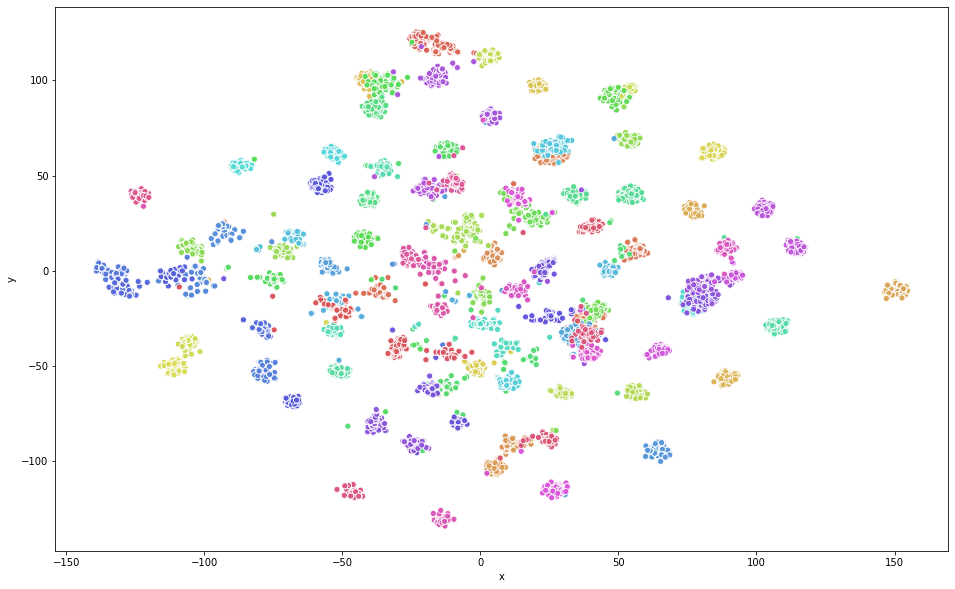

In [55]:
pd_tsne = pd.DataFrame(tsne_results, columns=["x", "y"])
pd_tsne['label'] = rx101f64_video_label_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 101),
    data=pd_tsne,
    legend=False,
    alpha=1
)

In [71]:
print(len(rx101f64_video_label_val), len(rx101f16_video_label_val))

3783 4217


In [72]:
idx_val = np.load('./idx_val.npy')
idx_val_f64 = np.load('./idx_val_f64.npy')
print(idx_val.shape, idx_val_f64.shape)

(45106,) (12591,)


In [74]:
clips_classname_val_f64 = np.load('./class_names_val_f64.npy')
clips_classname_val_f16 = np.load('./class_names_val.npy')
print(clips_classname_val_f64.shape, clips_classname_val_f16.shape)

(12591,) (45106,)


## MLP

In [83]:
### run experiment with MLP in keras
def fuseClipFeature(npy_1, npy_2):
    clips_feature_train_1 = np.load(npy_1 + '_train.npy')
    clips_feature_val_1 = np.load(npy_1 + '_val.npy')
    clips_feature_train_2 = np.load(npy_2 + '_train.npy')
    clips_feature_val_2 = np.load(npy_2 + '_val.npy')

    idx_train = np.load('./idx.npy')
    idx_val = np.load('./idx_val.npy')
    
    fuse_feature_train = preprocessing.normalize(np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=1))
    fuse_feature_val = preprocessing.normalize(np.concatenate((clips_feature_val_1, clips_feature_val_2), axis=1))
    #X_train, X_test, y_train, y_test = train_test_split(fuse_feature_train, idx_train, test_size=0.33, random_state=42)
    #return X_train, X_test, y_train, y_test, fuse_feature_val, idx_val
    return fuse_feature_train, idx_train, fuse_feature_val, idx_val

def fuseClipFeature64(npy_1, npy_2):
    clips_feature_train_1 = np.load(npy_1 + '_train.npy')
    clips_feature_val_1 = np.load(npy_1 + '_val.npy')
    clips_feature_train_2 = np.load(npy_2 + '_train.npy')
    clips_feature_val_2 = np.load(npy_2 + '_val.npy')


    idx_train = np.load('./idx_f64.npy')
    idx_val = np.load('./idx_val_f64.npy')
    
    fuse_feature_train = preprocessing.normalize(np.concatenate((clips_feature_train_1, clips_feature_train_2), axis=1))
    fuse_feature_val = preprocessing.normalize(np.concatenate((clips_feature_val_1, clips_feature_val_2), axis=1))
    #X_train, X_test, y_train, y_test = train_test_split(fuse_feature_train, idx_train, test_size=0.33, random_state=42)
    #return X_train, X_test, y_train, y_test, fuse_feature_val, idx_val
    return fuse_feature_train, idx_train, fuse_feature_val, idx_val

#X_train, X_test, y_train, y_test, fuse_feature_val, idx_val = fuseClipFeature('./I3D_avg_pool_1024', './resnext-101-kinetics_avgpool')
#X_train, y_train, X_test, y_test = fuseClipFeature('./I3D_avg_pool_1024', './resnext-101-kinetics_avgpool')
# X_train, y_train, X_test, y_test = fuseClipFeature64('./I3D_avg_pool_4096', './resnext-101-64f-kinetics_avgpool')
#X_train, y_train, X_test, y_test = fuseClipFeature64('./I3D_avg_pool_4096', './resnext-101-64f-kinetics-ucf101_split1_avgpool')
X_train, y_train, X_test, y_test = fuseClipFeature64('./I3D_avg_pool_4096', './resnext-101-64f-kinetics_avgpool')

In [109]:
X_train, y_train, X_test, y_test = fuse_video_feature_train, r18_video_label_train, fuse_video_feature_val, r18_video_label_val

In [52]:
X_train, y_train, X_test, y_test = rx101f64_video_features_train, rx101f64_video_label_train, rx101f64_video_features_val,\
        rx101f64_video_label_val

In [81]:
print(X_train.shape, X_test.shape)

(32381, 6144) (12591, 6144)


In [84]:
import os
import keras
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

num_classes = 101
if isinstance(y_train, list) or len(y_train.shape) == 1:
    y_train = [i-1 for i in y_train]
    y_test = [i-1 for i in y_test]
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)


os.environ['CUDA_VISIBLE_DEVICES']='2'
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# Train model on dataset
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=80,
                    verbose=1,
                    validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              6292480   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 101)               103525    
Total params: 6,396,005
Trainable params: 6,396,005
Non-trainable params: 0
_________________________________________________________________
Train on 32381 samples, validate on 12591 samples
Epoch 1/80
32381/32381 [==============================] - 2s 71us/step - loss: 1.3287 - acc: 0.7425 - val_loss: 0.4743 - val_acc: 0.8598
Epoch 2/80
32381/32381 [==============================] - 2s 66us/step - loss: 0.2944 - acc: 0.9125 - val_loss: 0.4158 - val_acc: 0.8721
Epoch 3/80
32381/32381 [==============================] - 2s 65us/step -

KeyboardInterrupt: 

In [85]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
###20 epoch, 0.8558 for clip train clip test, concatenate of i3d_f16 and rx101

Test loss: 0.6178010833019565
Test accuracy: 0.9038996108426026


## Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression
X_train, y_train, X_test, y_test = fuseVideoFeature16('./c3d_fc6', './resnet-18-kinetics_avgpool', 'ucf101')

clf = LogisticRegression(random_state=0, tol=1e-5)
#clf = SVC()
clf.fit(preprocessing.normalize(X_train), y_train)

predict = clf.predict(preprocessing.normalize(X_test))
accuracy_score(y_test, predict)

(115550, 4096)
(115550,)
(115550,)
video num: (9537, 4096)
(115550, 512)
(115550,)
(115550,)
video num: (9537, 512)


0.8651863600317209

In [91]:
import os
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

os.environ['CUDA_VISIBLE_DEVICES']='2'
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return batch_x, batch_y

training_generator = DataGenerator(X_train, y_train, 128)
validation_generator = DataGenerator(X_test, y_test, 128)